# 👋 Hello MNIST with Rockpool
Rockpool is a neural network training library, with a focus on spiking neural networks (SNNs) and other neurons that have internal state and temporal dynamics.

The goal is to make training and deploying SNNs as simple as training a standard DNN.
Here we show the steps to train the MNIST digit classification task — a common dataset for getting started with neural network libraries.

In [11]:
# - Install required packages
import sys


In [12]:
# - Basic imports
import torch
import torchvision

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange

from IPython.display import Image

## Spiking neurons
The main difference between a *spiking* neuron (SN) and a standard artificial neuron (AN) is in their understanding of time.
Standard ANs operate instantaneously, by simply summing their weighted inputs and applying a transfer function such as a ReLU.
*Spiking* neurons, on the other hand, have an internal state that evolves over time in response to their input.

As a result, SNNs are great for processing temporal signals — and as a consequence, we need to consider how to provide input data to an SNN over time, and consider e.g. the *time constants* $\tau$ as additional network parameters.

WARNING    <>:18: SyntaxWarning: invalid escape sequence '\T'
 [py.warnings]
WARNING    <>:18: SyntaxWarning: invalid escape sequence '\T'
 [py.warnings]
WARNING    /tmp/ipykernel_154341/3546265263.py:18: SyntaxWarning: invalid escape sequence '\T'
  plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
 [py.warnings]


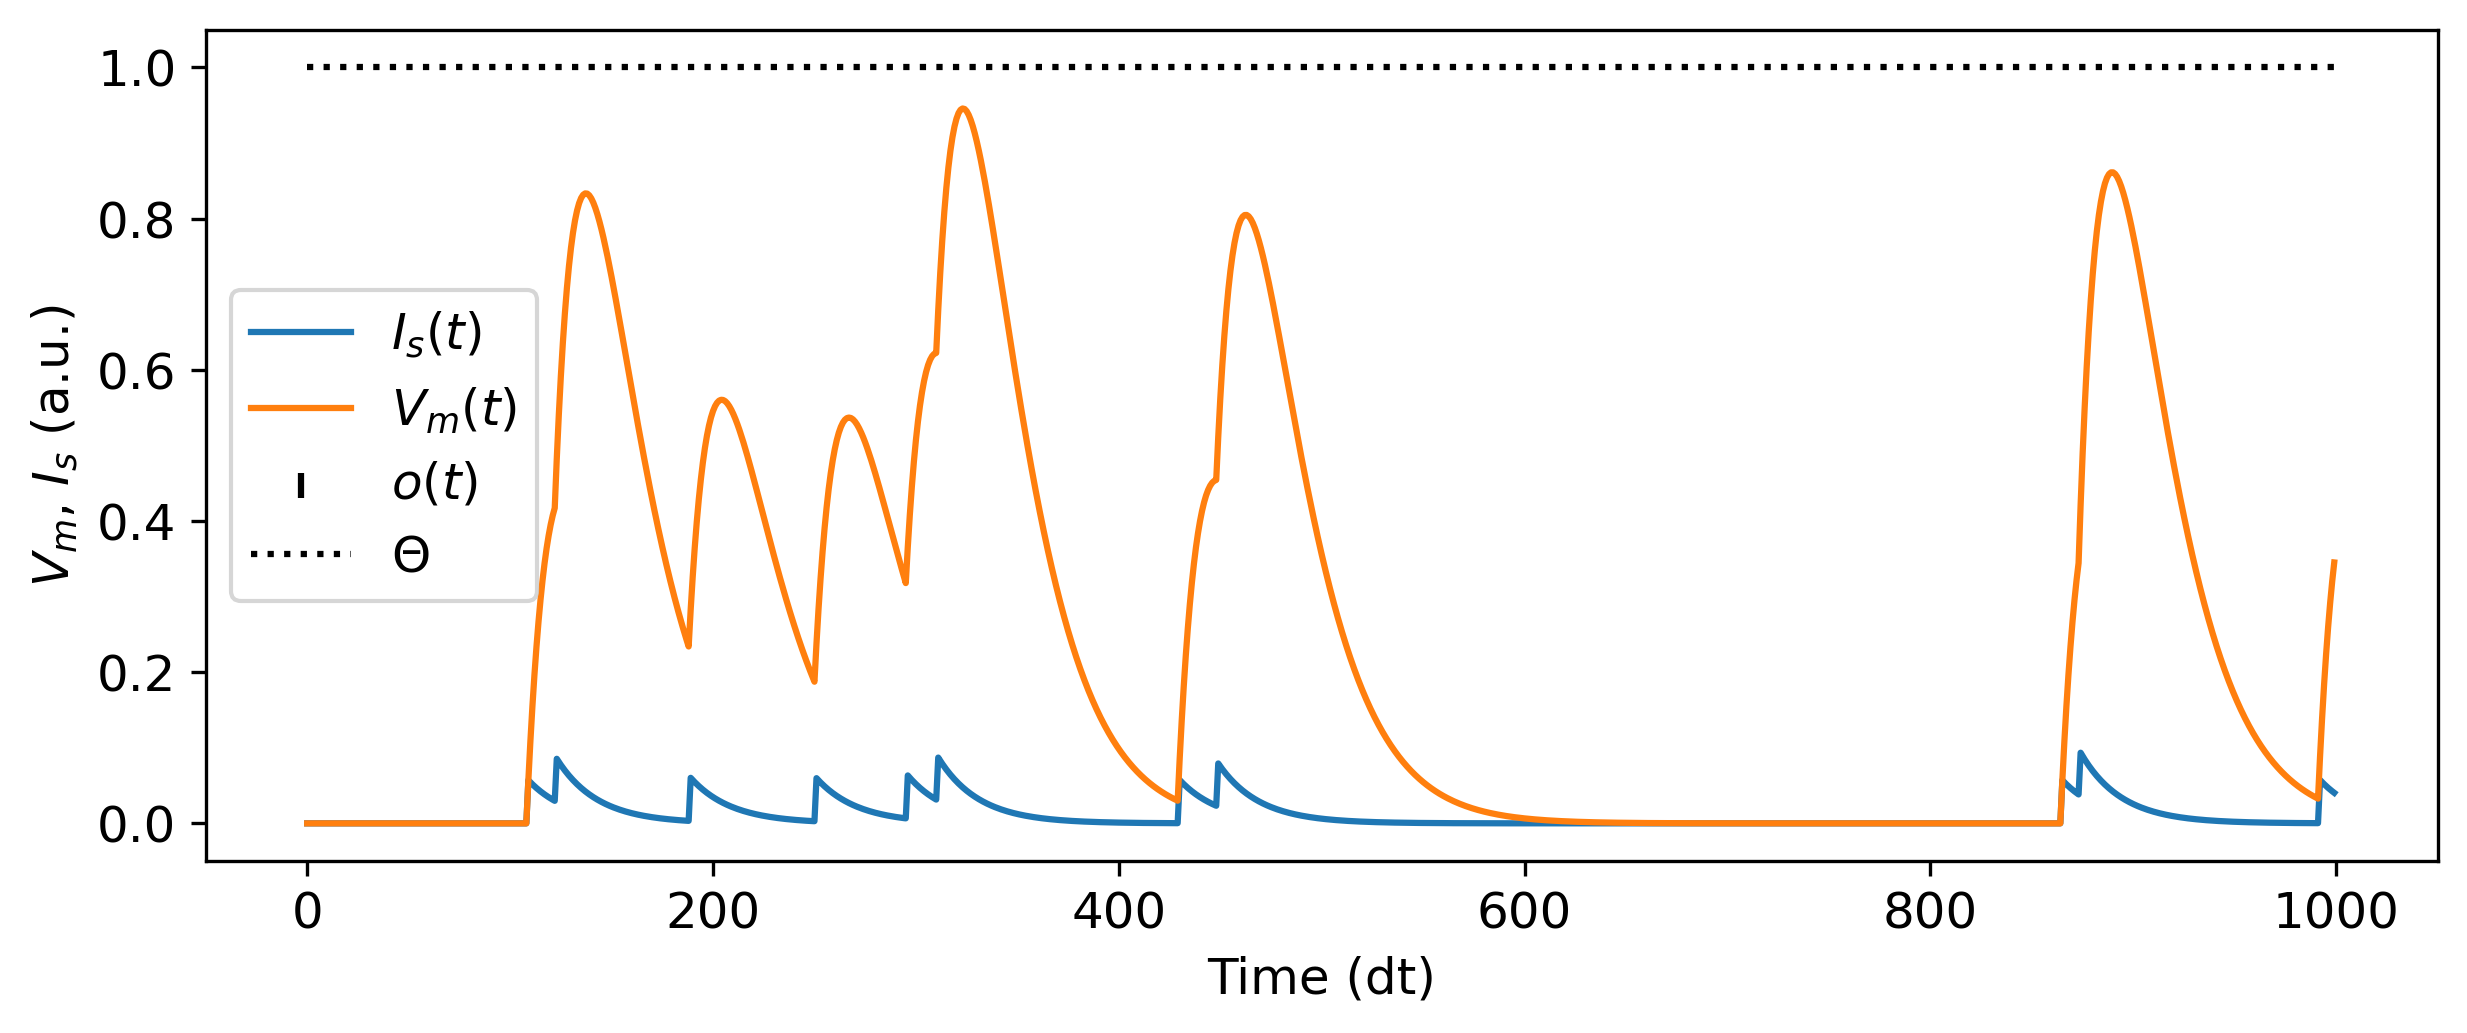

In [13]:
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF

# - Generate a spiking neuron
neuron = LIF(1)

# - Simulate this neuron for 1 sec with poisson spiking input z(t)
num_timesteps = int(1/neuron.dt)
input_z = 0.06 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# - Display the input, internal state and output events
plt.figure()
plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
b, t, n = np.nonzero(output)
plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$')
plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$, $I_s$ (a.u.)')
plt.legend();


## Data and encoding
Now we can load the MNIST dataset, and decide how to encode the data for processing by an SNN.
We make use of the `torchvision` package to obtain the MNIST dataset and manage the dataset and data loader classes.

The data will be accessed as `torch.Tensor` objects.

In [14]:
# - Number of samples per batch
batch_size = 256

# - Download and access the MNIST training dataset
train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# - Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

# - Create a test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
)

Now we need to decide how to encode the data samples for the SNN.
The MNIST samples are $28 \times 28$ resolution images, with no temporal component.
We will encode the images by arranging the $28 \times 28$ pixels into a 784-element vector, and creating 784 spiking input channels.
We'll use a Poisson process to generate an average input rate for each channel, according to the intensity of the corresponding pixel.
Pixels with value `0` will have generate no input events; pixels with value `1` will generate the highest rate of events.
To do so we need to define how many time-steps each sample will take, and what the duration of a single time-step will be.

In [15]:
# - Define the temporal aspects of a data sample
num_timesteps = 100
dt = 10e-3

# - Extract the number of classes and input channels
num_classes = len(torchvision.datasets.MNIST.classes)
input_channels = train_data[0][0].numel()

# - Define a function to encode an input into a poisson event series
def encode_poisson(data: torch.Tensor, num_timesteps: int, scale: float = 0.1) -> torch.Tensor:
  num_batches, frame_x, frame_y = data.shape
  data = scale * data.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
  return (torch.rand(data.shape) < (data * scale)).float()

We also need to determine what the target output of the network will look like.
The MNIST dataset has 10 classes.
We'll build a network with 10 output neurons, one for each class, and train the network to produce a high event rate for the target class and no events for the non-target classes.
Our target will also be a time series of events, with the same duration as the input time series, and with 10 channels.

In [16]:
# - Define a function to encode the network target
def encode_class(class_idx: torch.Tensor, num_classes: int, num_timesteps: int) -> torch.Tensor:
  num_batches = class_idx.numel()
  target = torch.nn.functional.one_hot(class_idx, num_classes = num_classes)
  return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()

Text(0.5, 1.0, 'Target')

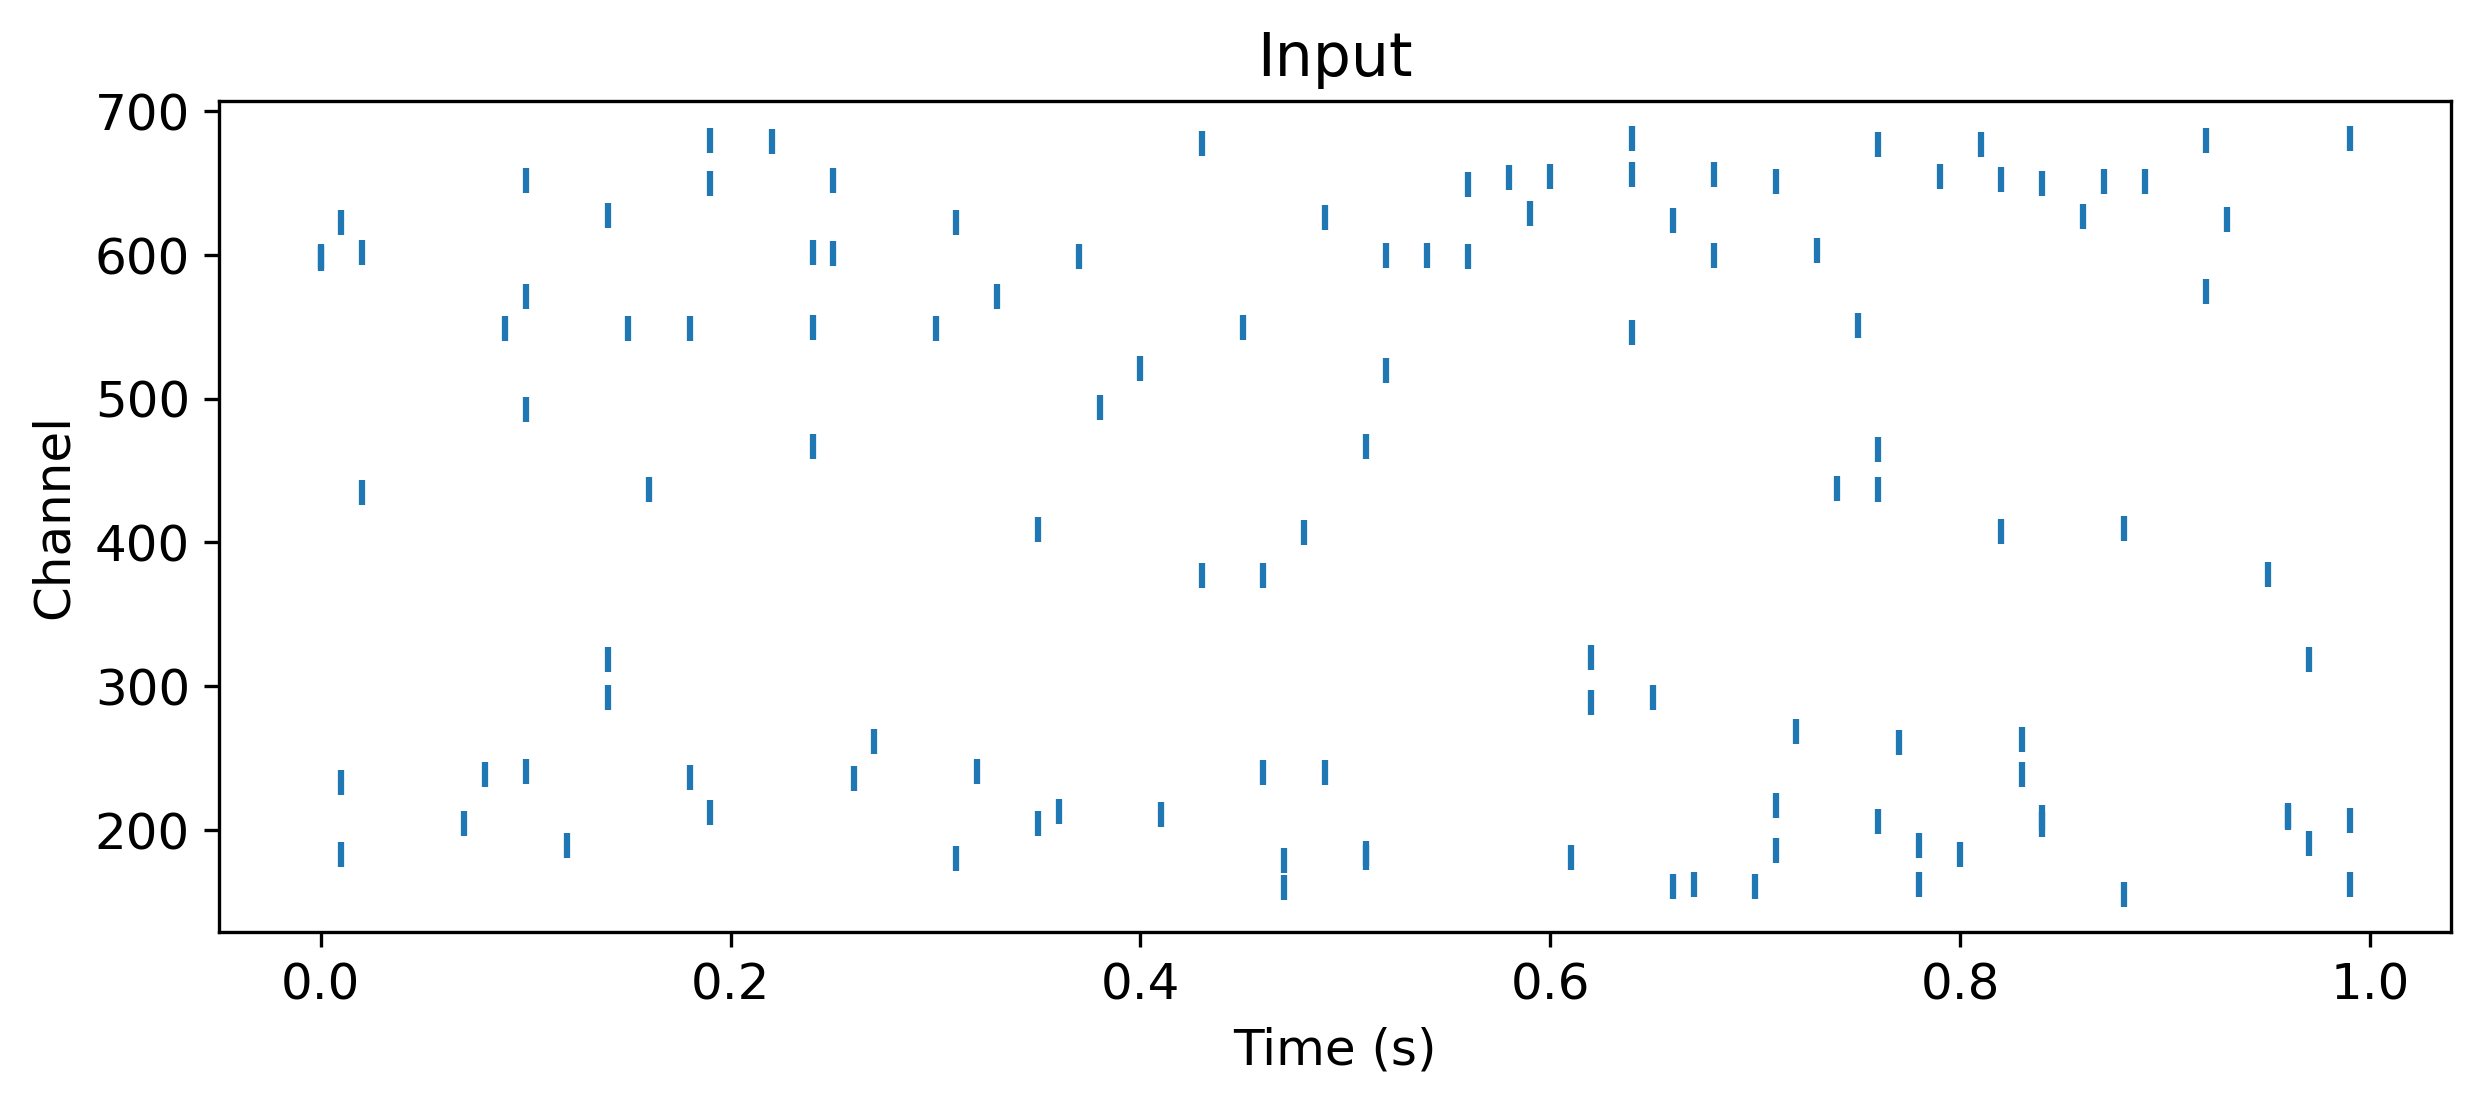

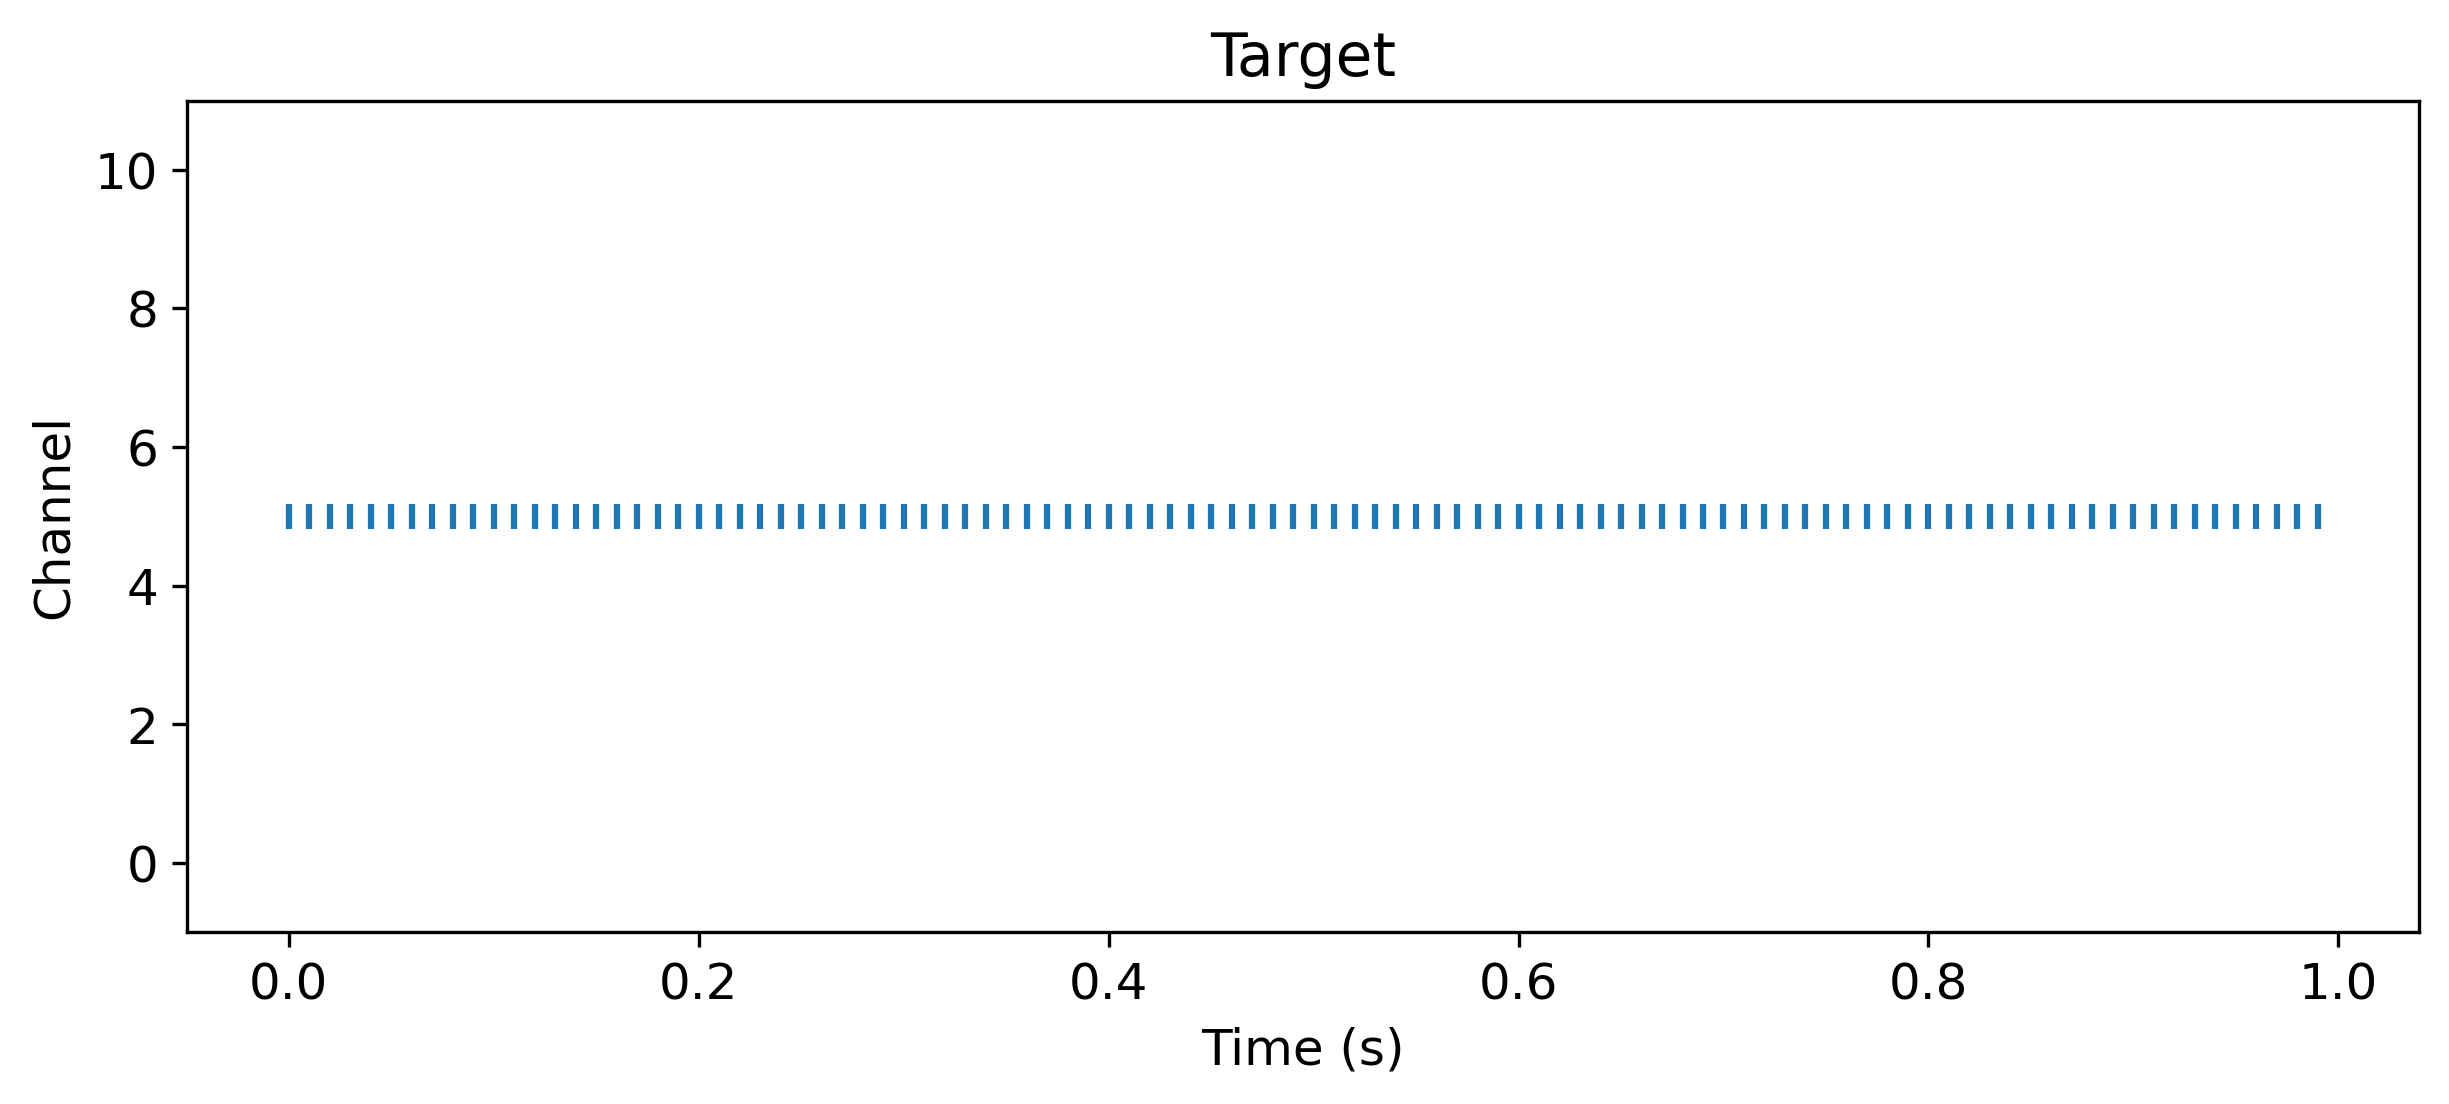

In [17]:
# - Get one sample
frame, class_idx = train_data[0]

# - Encode the input and targets
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# - Plot the poisson input for this sample
plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker = '|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

# - Plot the target event series for this sample
b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker = '|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target')

## Building a network
Rockpool allows you to build SNNs with a simple syntax, similar to PyTorch.
We support several computational back-ends in Rockpool, one of which is PyTorch, which we will use here.

`LIFTorch` is a Rockpool and `torch` module which provides a trainable simulation of LIF spiking neurons.
`LinearTorch` is a linear weight matrix, comparable to the torch `nn.Linear` module.

To build simple feed-forward networks, we use the `Sequential` combinator from Rockpool, which functions like the torch `nn.Sequential` combinator.

By default, Rockpool allows you to train the time constants $\tau$ and other parameters of an SNN.
For simplicity, here we'll define them as constant (i.e. non-trainable), using the `Constant` parameter decorator.

The network architecture we will use is shown below; a simple two-layer SNN.

In [18]:
Image('mnist-architecture.png')

FileNotFoundError: No such file or directory: 'mnist-architecture.png'

FileNotFoundError: No such file or directory: 'mnist-architecture.png'

<IPython.core.display.Image object>

In [19]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_hidden = 64
tau_mem = Constant(100e-3)
tau_syn = Constant(50e-3)
threshold = Constant(1.)
bias = Constant(0.)

# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden)),
    LIFTorch(num_hidden, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (784, 10) {
    LinearTorch '0_LinearTorch' with shape (784, 64)
    LIFTorch '1_LIFTorch' with shape (64, 64)
    LinearTorch '2_LinearTorch' with shape (64, 10)
    LIFTorch '3_LIFTorch' with shape (10, 10)
}


Let's examine the un-trained output of this network.
We simulate the network identically as with the single LIF neuron above, just by passing input data to the module.
We'll use the single data sample we encoded above.
The `record = True` argument tells Rockpool to record all the internal state of the SNN during evolution.

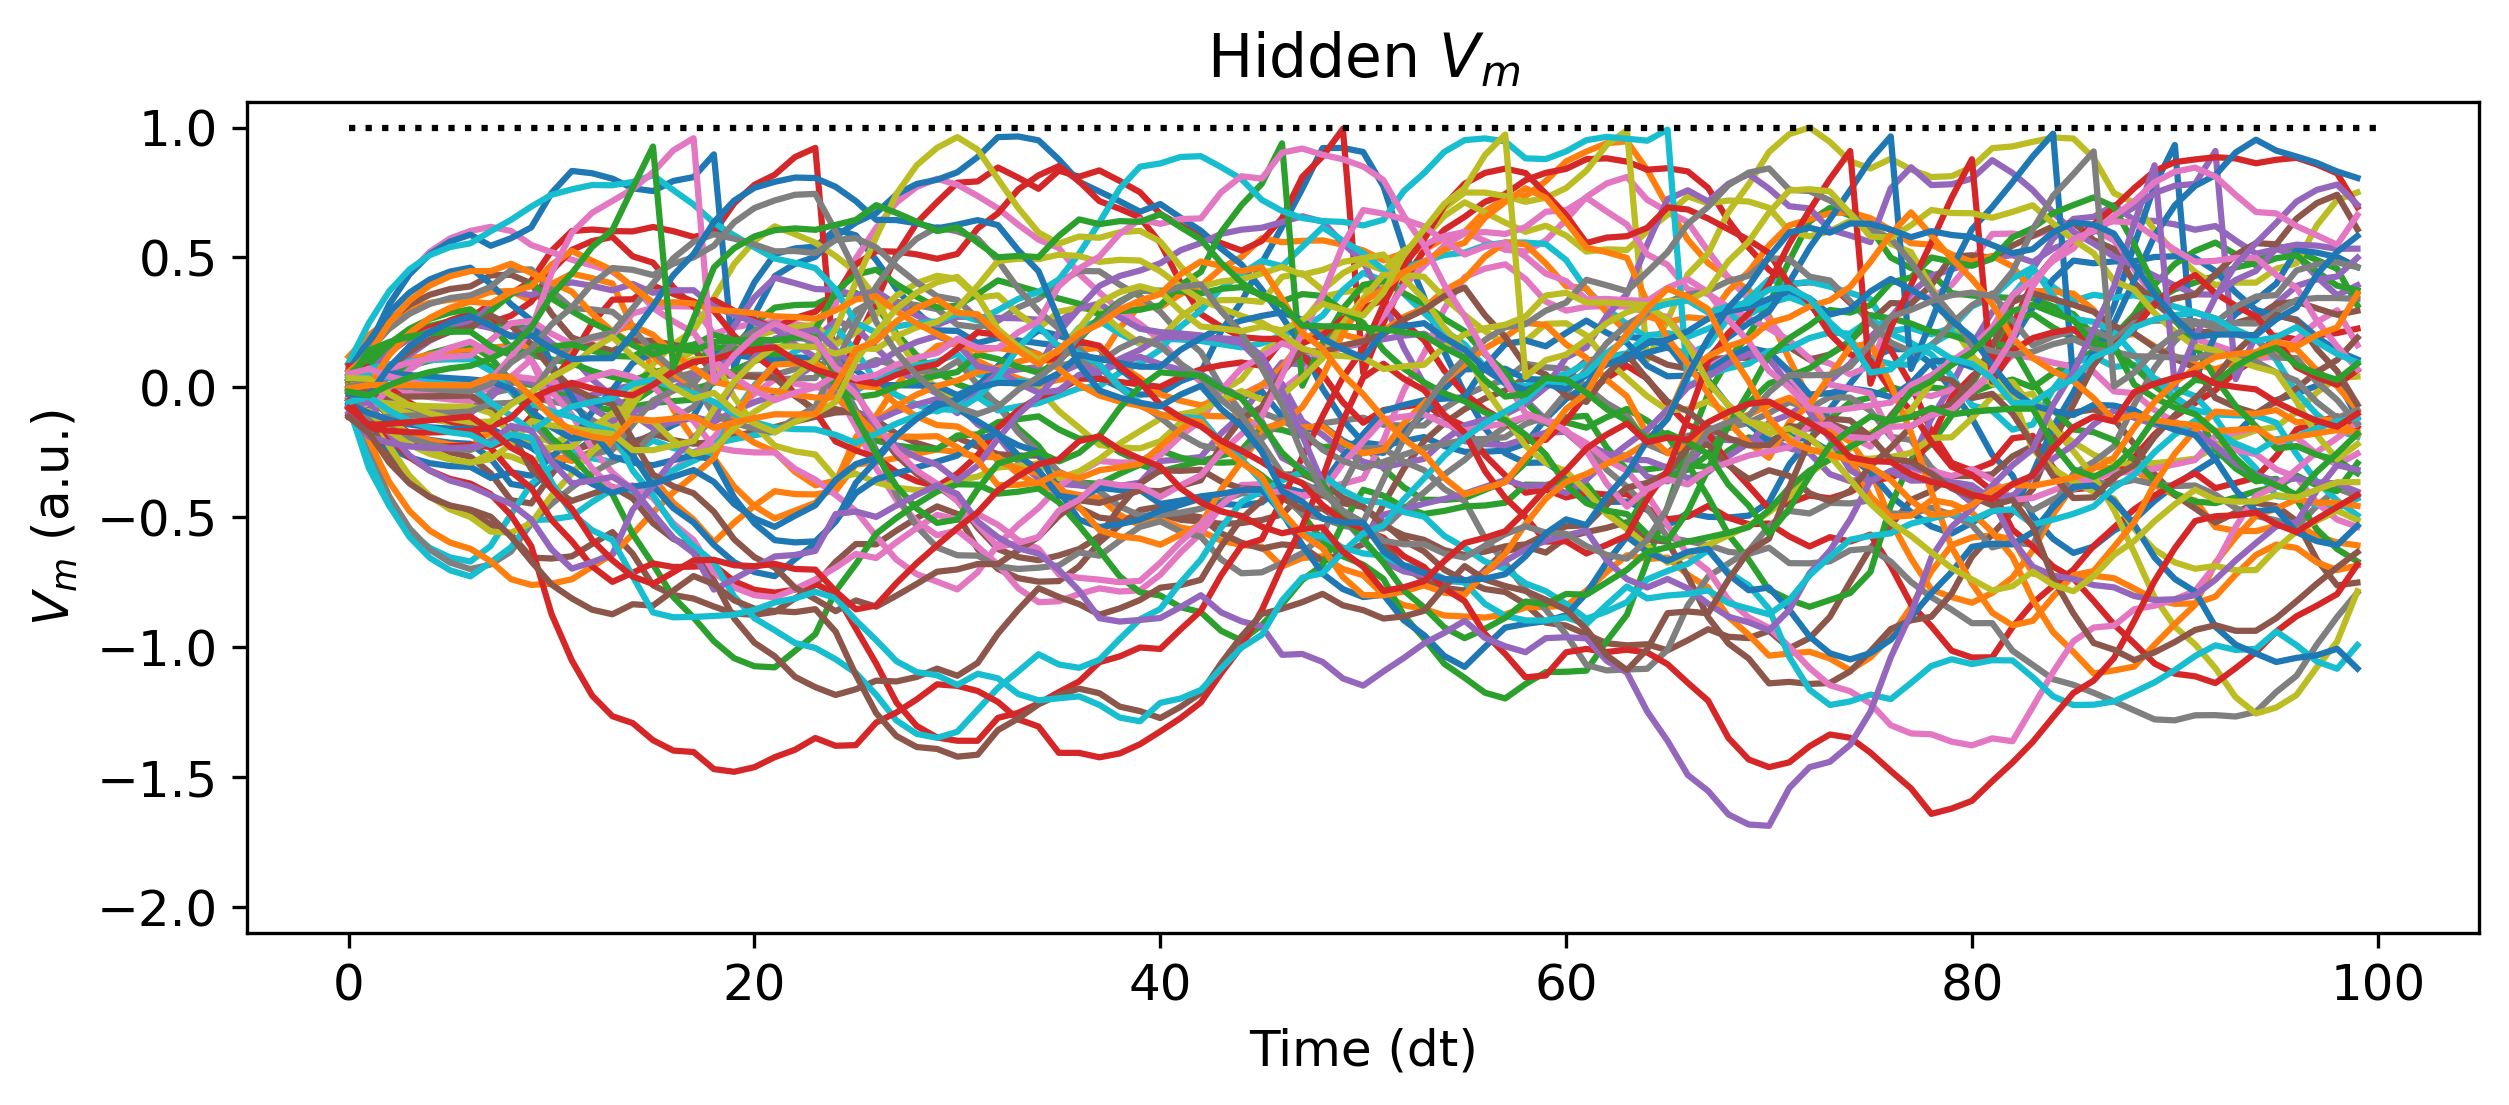

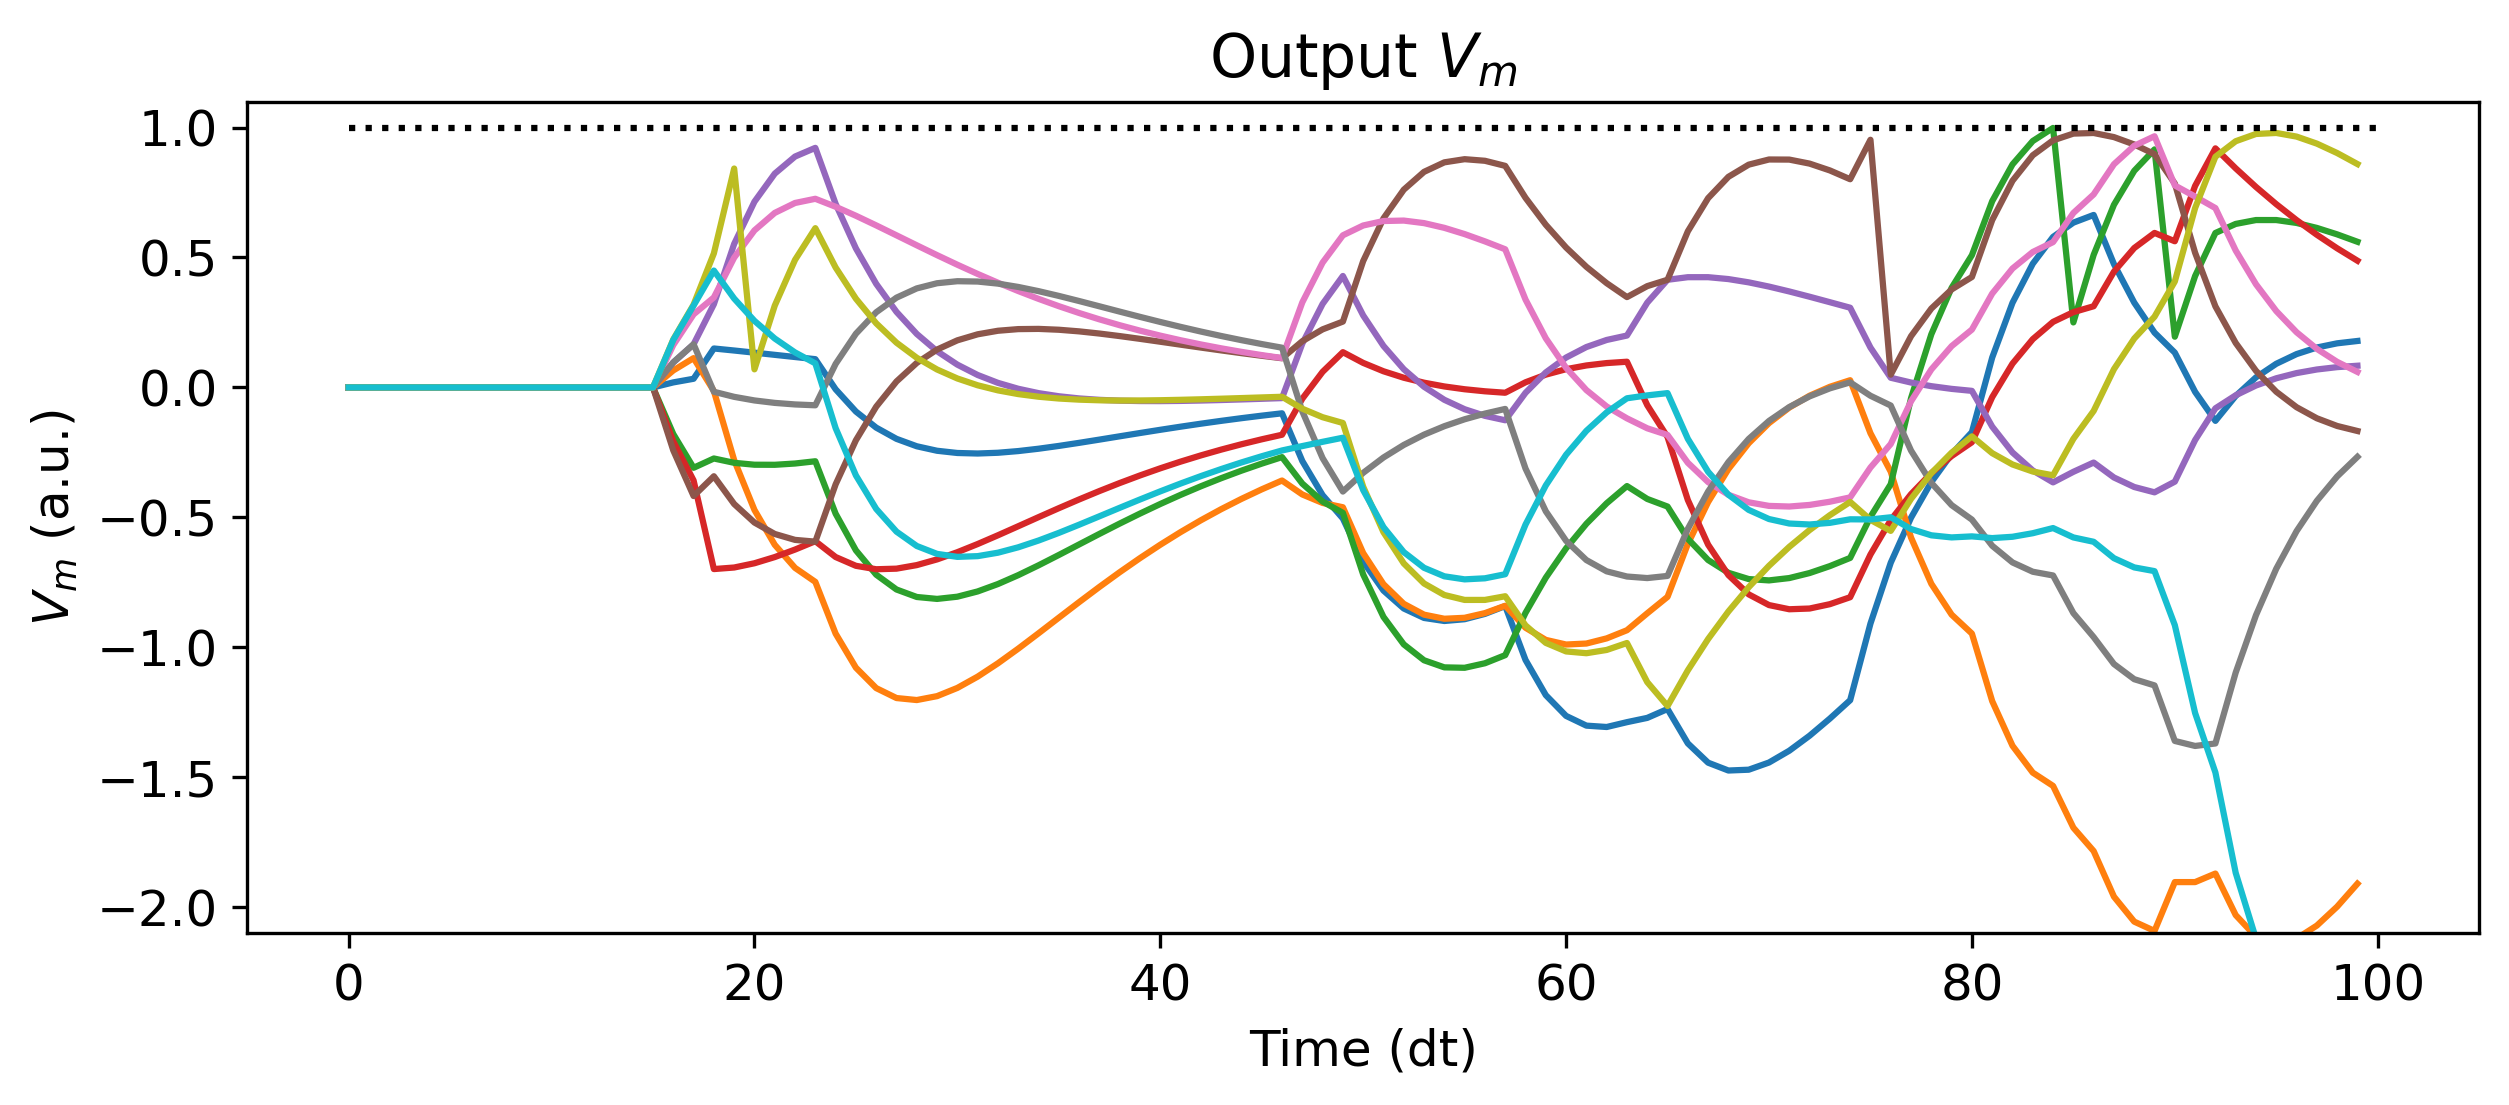

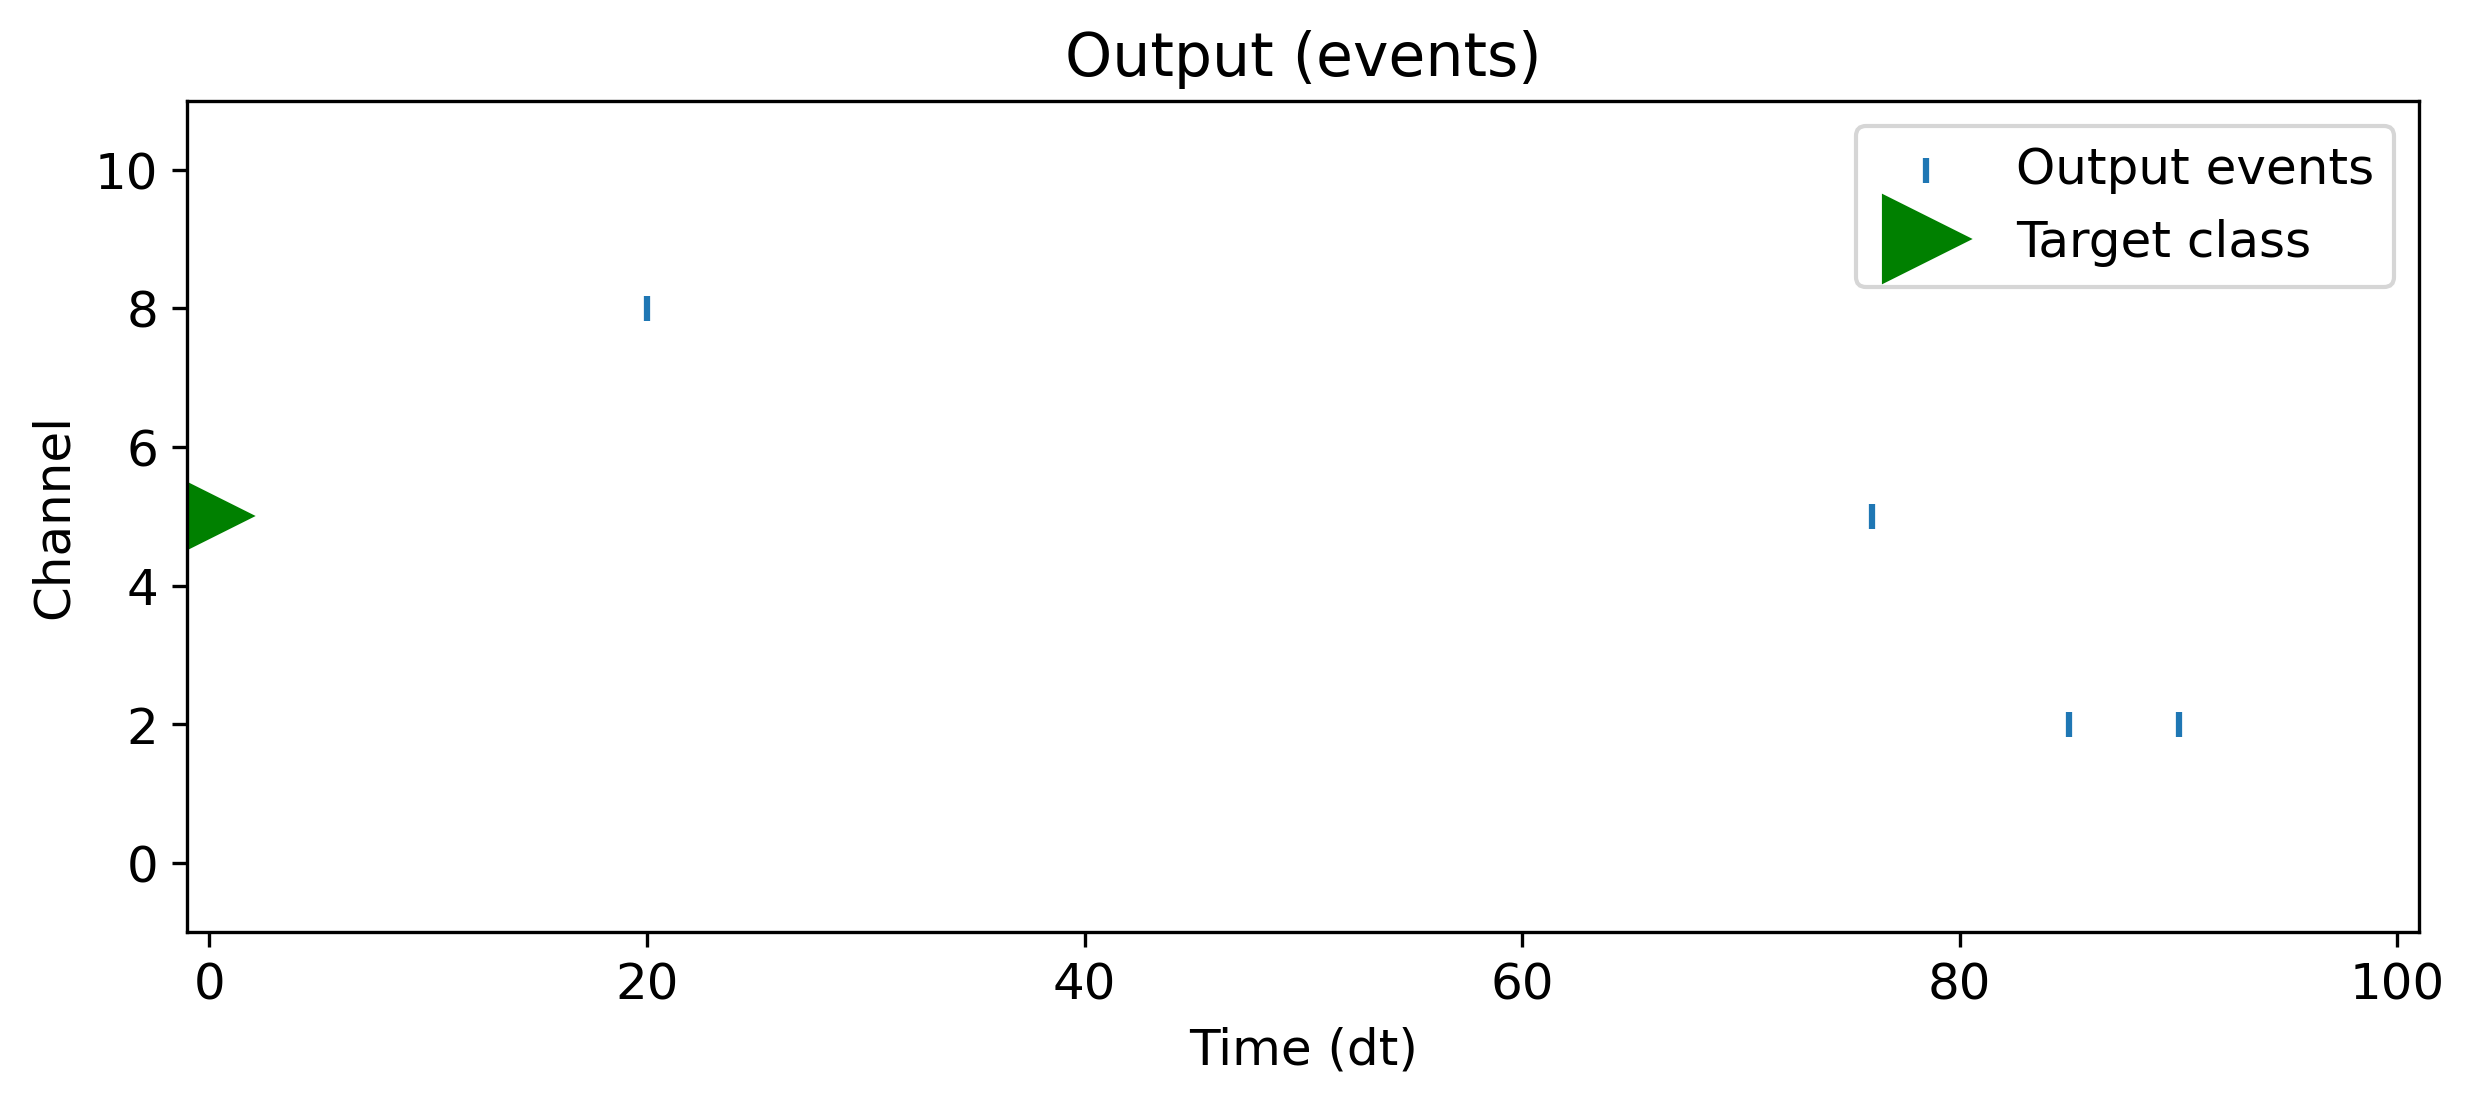

In [20]:
# - Simulate the untrained network, record internal state
output, _, rec_dict = snn(data, record = True)

# - Display the internal state and output
plt.plot(rec_dict['1_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Hidden $V_m$')

plt.figure()
plt.plot(rec_dict['3_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Output $V_m$')

plt.figure()
t, n = torch.nonzero(rec_dict['3_LIFTorch_output'][0].detach(), as_tuple = True)
plt.scatter(t, n, marker = '|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();

## Optimization
Rockpool links in to the `torch` automatic differentiation pipeline, to provide end-to-end gradient-based training of SNNs.
We can natively use losses and optmizers from `torch.optim`, such as `Adam`.
The `.astorch()` method converts the Rockpool parameter dictionary into a form identical to that of `torch`.

In [21]:
from torch.optim.adam import Adam

# - Initialise the optimizer with the network parameters
optimizer = Adam(snn.parameters().astorch())

Thanks to the close integration with `torch`, we can use CUDA-based GPU acceleration for training, the same as with a standard `torch` network.

In [22]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Now we will define a simple training loop, and a test function.
This boilerplate code is identical to that required for any other `torch` model.

In [23]:
def train(model, device, train_loader, optimizer):
  # - Prepare model for training
  model.train()
  losses = []

  # - Loop over the dataset for this epoch
  for data, class_idx in tqdm(train_loader, leave=False, desc='Training', unit='batch'):
    # - Encode input and target
    data = encode_poisson(data.squeeze(), num_timesteps)
    target = encode_class(class_idx, num_classes, num_timesteps)

    # - Zero gradients, simulate model
    optimizer.zero_grad()
    output, _, _ = model(data.to(device))

    # - Compute MSE loss and perform backward pass
    loss = torch.nn.functional.mse_loss(output, target.to(device))
    loss.backward()
    optimizer.step()

    # - Keep track of the losses
    losses.append(loss.item())

  return losses

In [24]:
def test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        input = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(input.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

Let's see how well the untrained network performs.

In [25]:
# - Initial loss and accuracy
test_loss, test_acc = test(snn.to(device), device, test_loader)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%')

Initial test loss 0.00042394218519330027, accuracy 8.09%


Now we can train for several epochs, and see if we can improve performance.

Training: 100%|██████████| 3/3 [04:43<00:00, 94.62s/epoch, test_acc=85.15%, test_loss=0.000355]


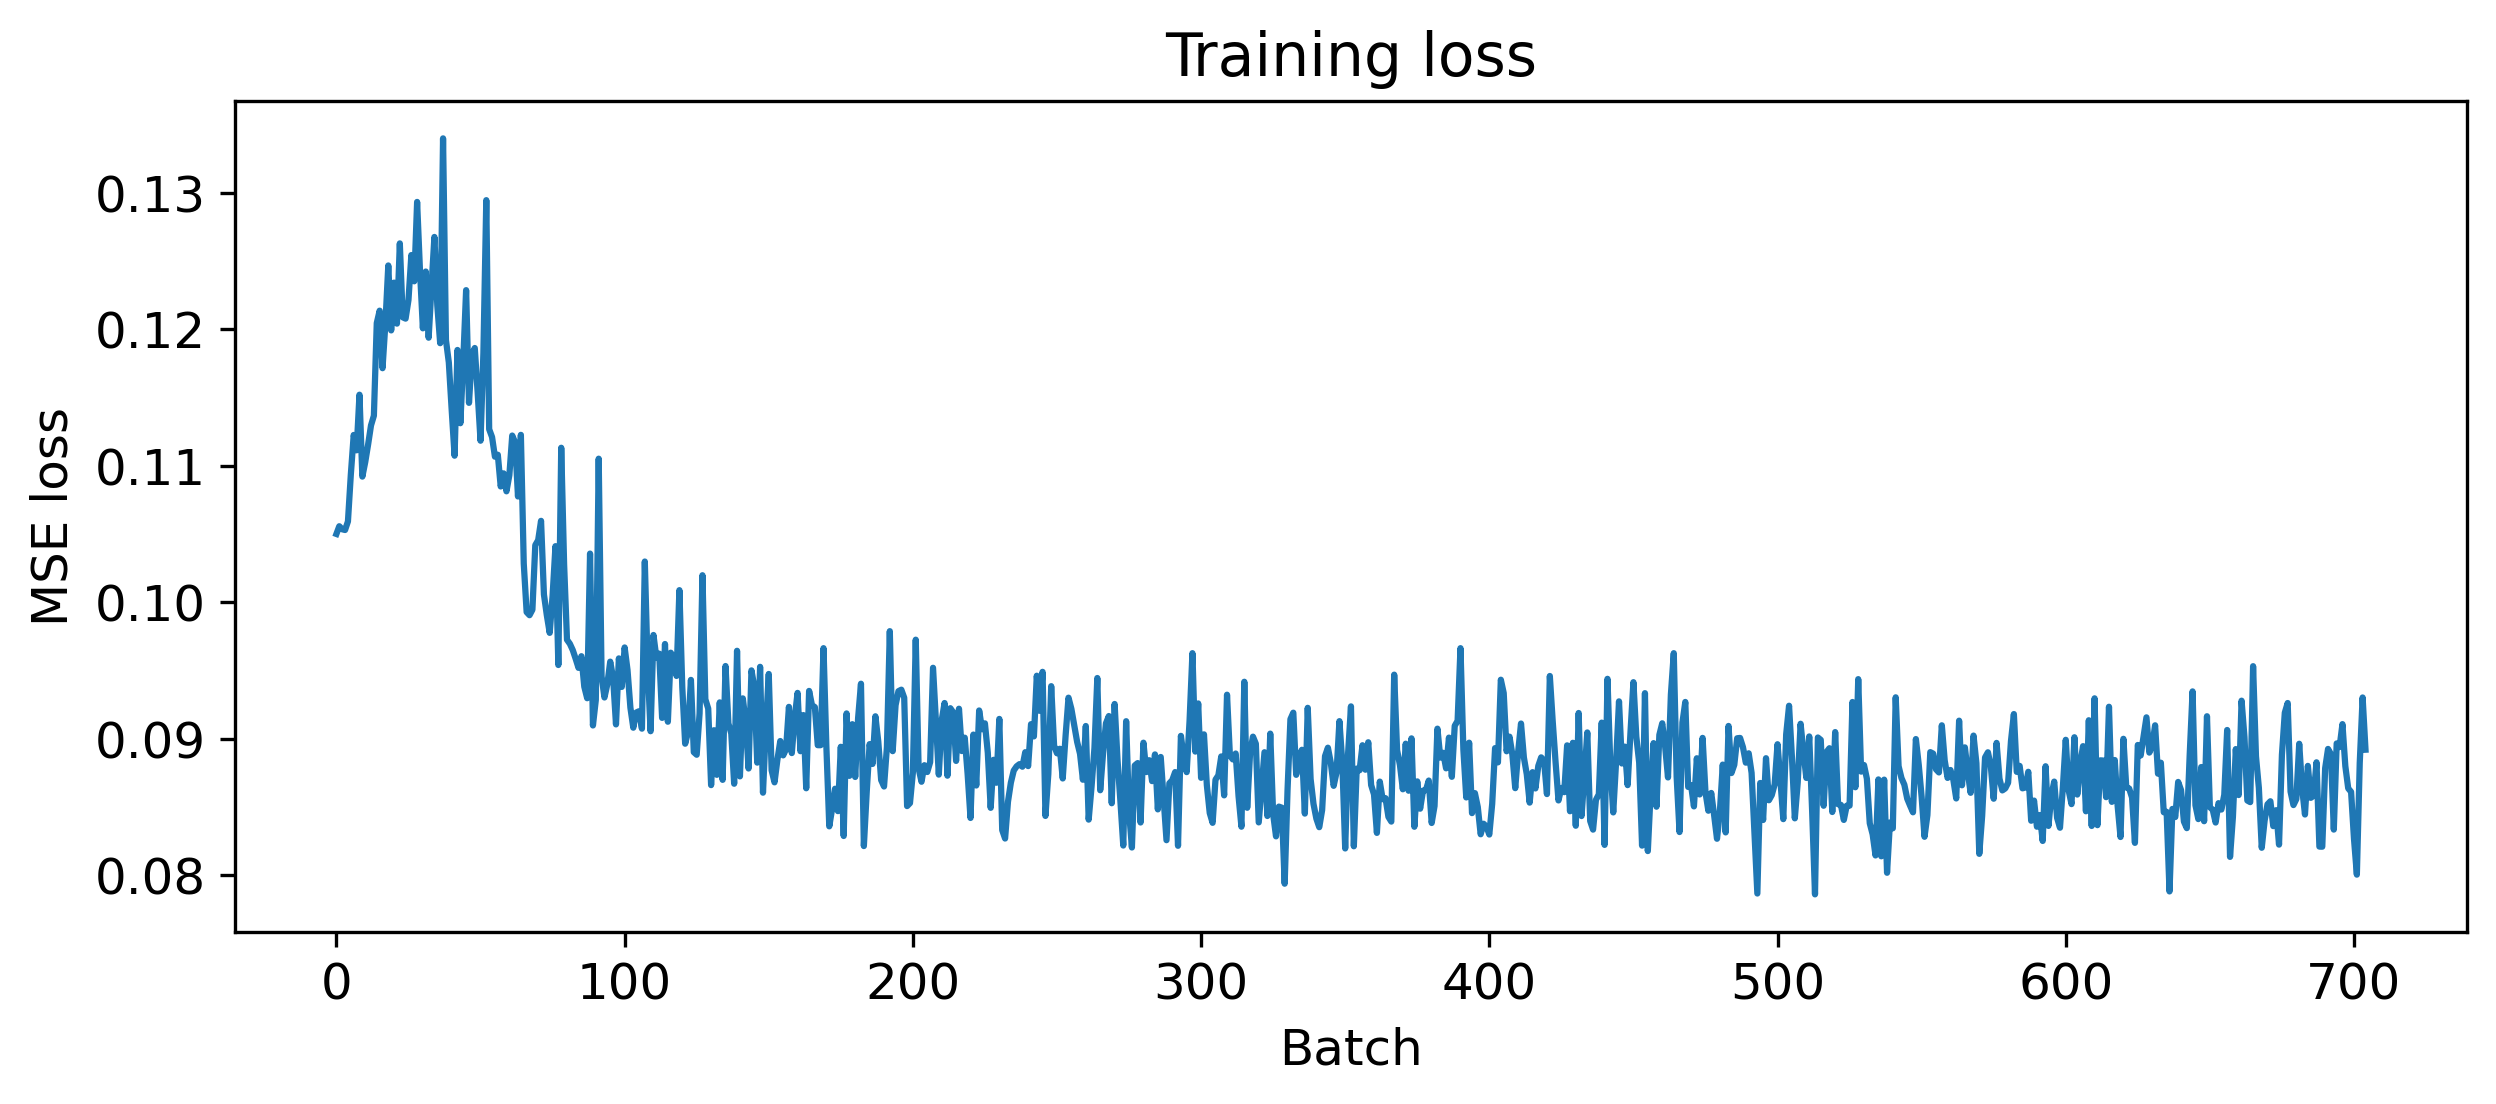

In [26]:
# - Train some epochs
num_epochs = 3

all_losses = []
ep_loop = trange(num_epochs, desc='Training', unit='epoch')
for epoch in ep_loop:
  ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
  losses = train(snn.to(device), device, train_loader, optimizer)
  all_losses.extend(losses)
  
  # - Get test loss and accuracy
  test_loss, test_acc = test(snn.to(device), device, test_loader)

plt.plot(all_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Training loss');

In [27]:
# - Trained loss and accuracy
print(f'Final test loss {test_loss}, accuracy {test_acc}%')

Final test loss 0.0003384882815182209, accuracy 85.85%


Looks good! We definitely learned something.
Let's take a look at the output on a single sample.

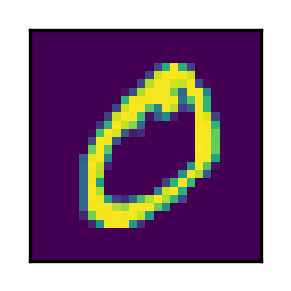

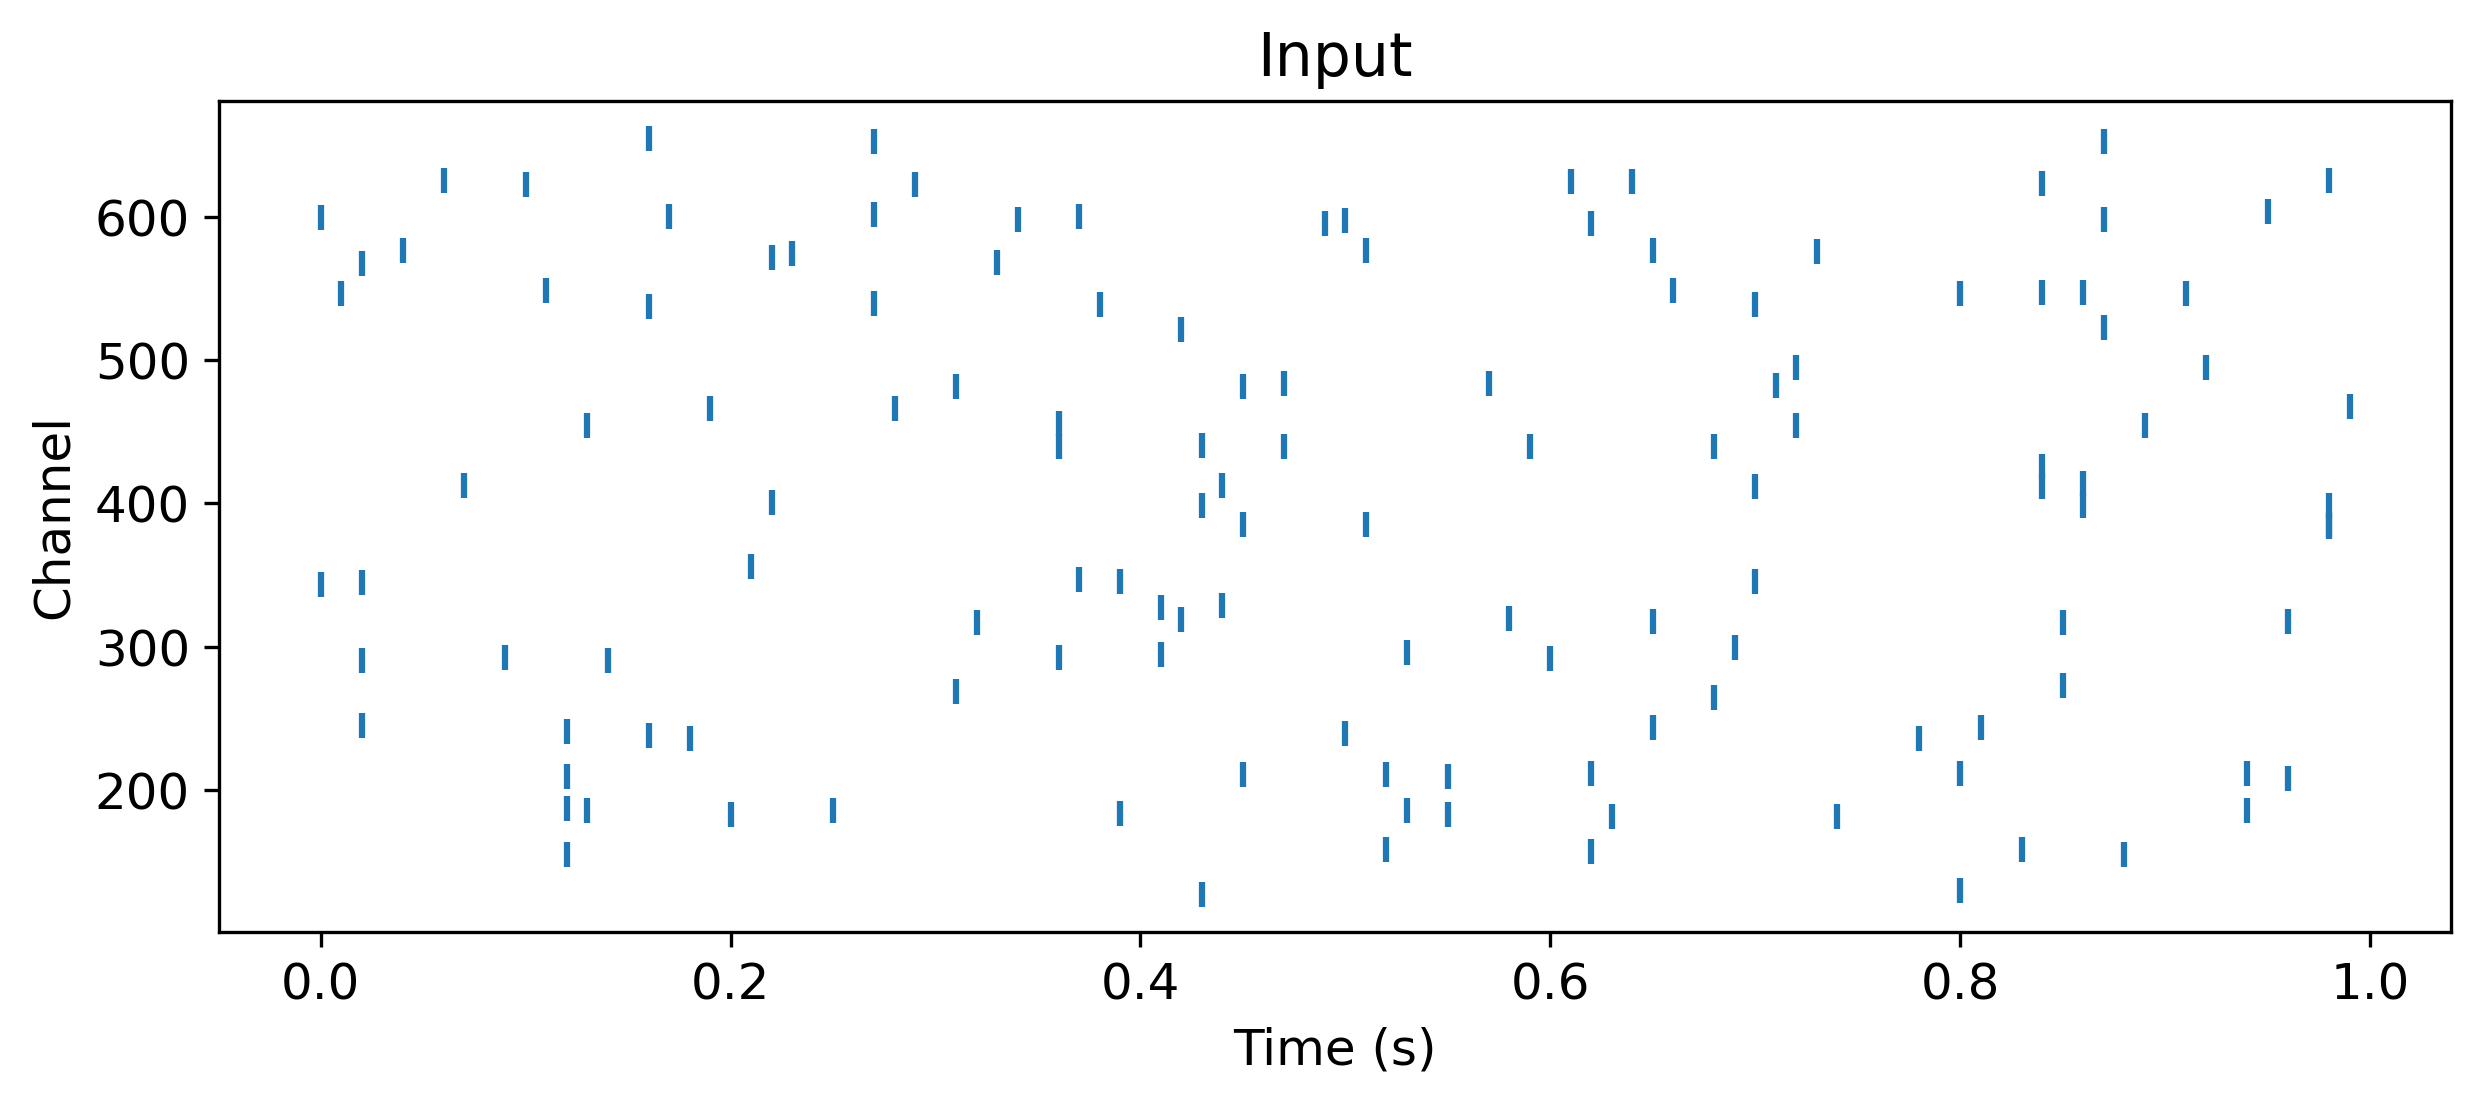

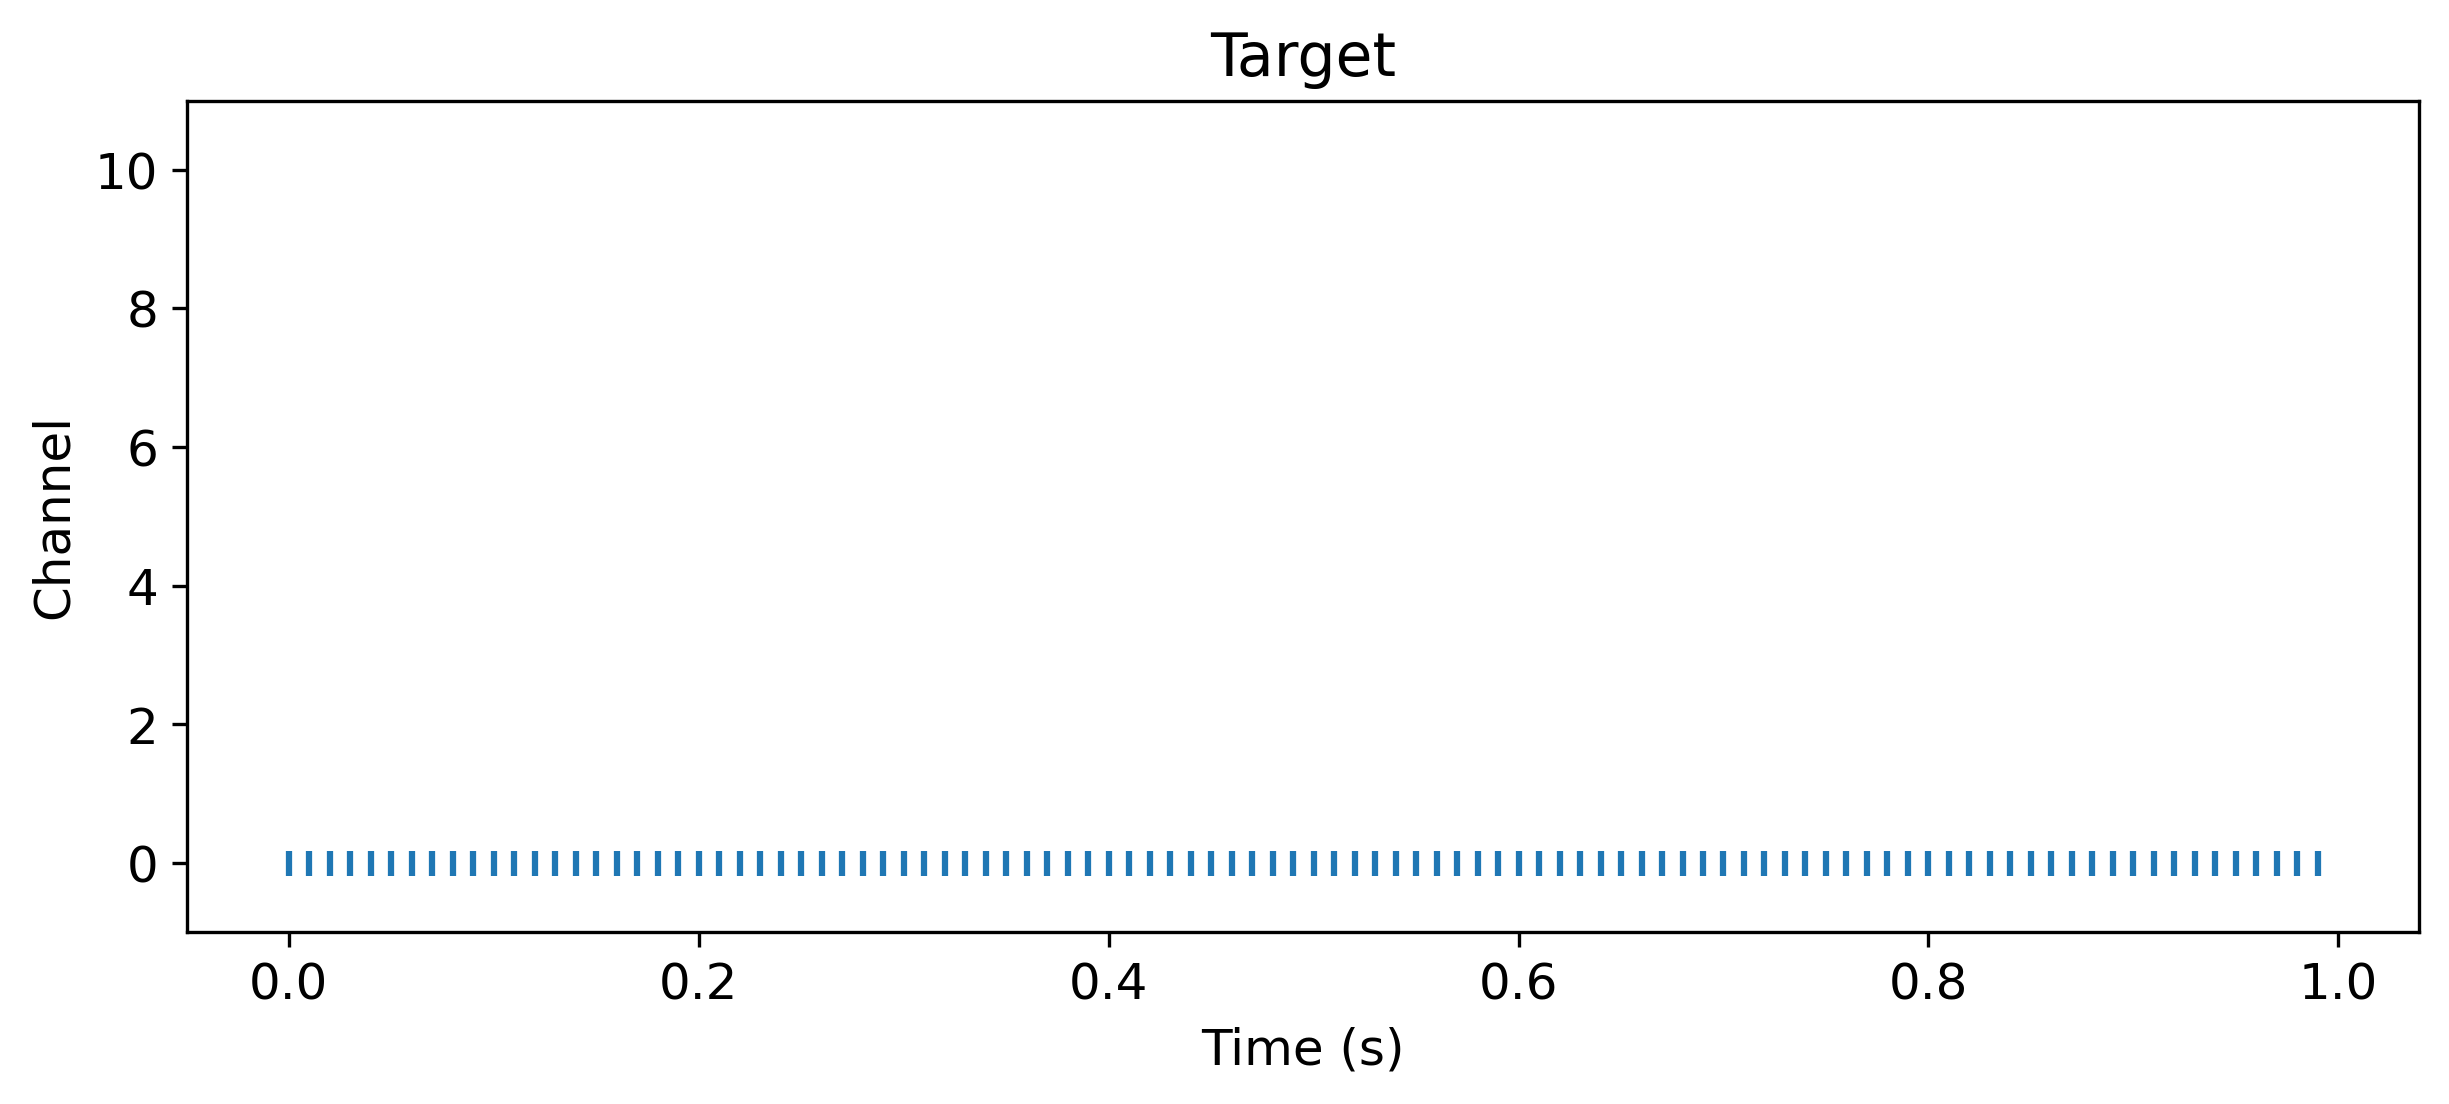

In [28]:
# - Pull a single test sample and display it
frame, class_idx = train_data[1]
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

plt.figure(figsize=(1, 1))
plt.imshow(frame[0])
plt.xticks([])
plt.yticks([])

plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker='|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker='|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target');

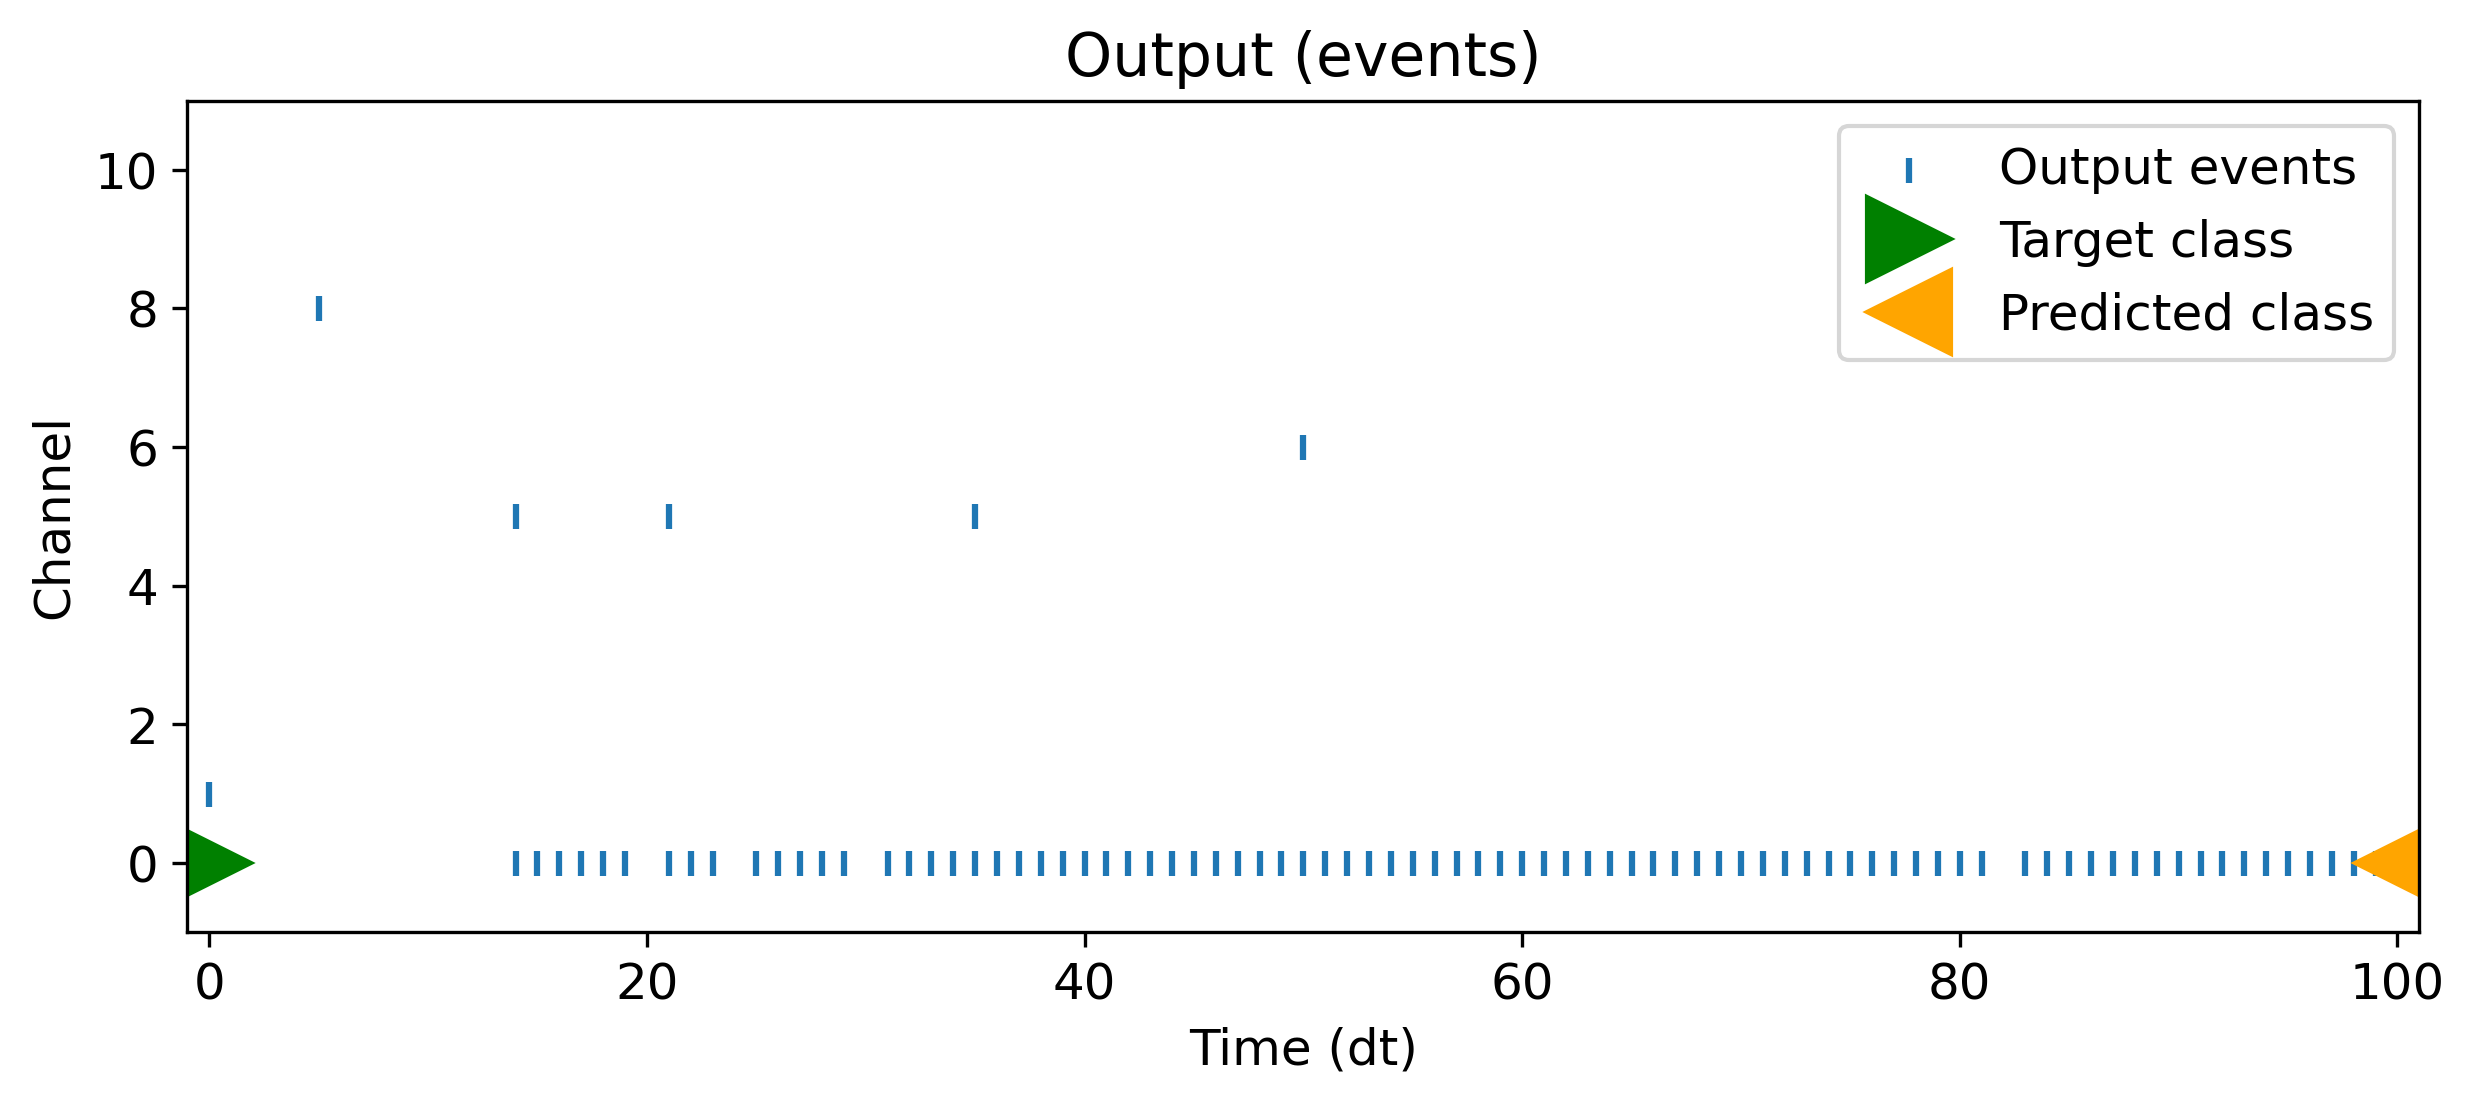

In [29]:
# - Simulate the network with this sample
output, _, _ = snn.cpu()(data)
pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()

# - Display the network output
b, t, n = torch.nonzero(output, as_tuple=True)

plt.scatter(t, n, marker='|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.plot(100, pred, '<', c='orange', markersize=20, label='Predicted class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();

## Next steps
The performance of the network could of course be improved in various ways:

 * Deeper or more complex network architecture
 * More hidden neurons
 * Training time constants $\tau$ and other parameters
 * Different loss function or output encoding

Now you've seen how to solve a simple vision task with Rockpool, check out other tutorials for more difficult temporal tasks, advanced training approaches, and hardware-aware training and deployment.